#**Pré-processamento**

In [31]:
from google.colab import drive 
drive.mount('/content/gdrive')

import pandas as pd
import seaborn as sns
import missingno as msno
import warnings
from matplotlib import pyplot as plt
import datetime
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

df = pd.read_csv("gdrive/My Drive/dissertação/Qualidade_do_ar_-_Dados_horarios.csv",sep=",")
df['Data']=df['Data'].astype('str')
df['Data']=df['Data'].apply(lambda x: x[:-3])

#conversão para datetime
def convert_to_datetime(x):
    return(datetime.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
df['Data']=df['Data'].apply(convert_to_datetime) 
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-8:-3])
# #extrair ano, mes, hora 
df['Ano']=df['Data'].apply(lambda x: x.year)
df['Mês']=df['Data'].apply(lambda x: x.month)
df['Dia']=df['Data'].apply(lambda x: x.day)
df['Hora']=df['Data'].apply(lambda x: x.hour)
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-11:-6])

df_bg=df[df['Estação']=='BG'] #Bangu
df_gc=df[df['Estação']=='CG'] #Campo Grande
df_ca=df[df['Estação']=='CA'] #Centro
df_av=df[df['Estação']=='AV'] #Copacabana
df_ir=df[df['Estação']=='IR'] #Irajá
df_pg=df[df['Estação']=='PG'] #Pedra de Guaratiba
df_sc=df[df['Estação']=='SC'] #São Cristóvão
df_sp=df[df['Estação']=='SP'] #Tijuca

df_sc.set_index('Data',inplace=True)
df_sc.drop(columns=['OBJECTID','CodNum','Estação','Dir_Vento','NO2','HCNM','HCT','CH4','NO','NOx',\
                   'PM2_5', 'Lat', 'Lon', 'X_UTM_Sirgas2000','Y_UTM_Sirgas2000'], inplace=True)
df_sc_2=df_sc.copy() #para fazer distribuição sem eliminar ausentes

df_sc=df_sc['2011-01-01':'2018-01-01']
#explicar que usou interpolação linear com spline e justificar
df_sc['Chuva'].interpolate(method='slinear', inplace=True)
df_sc['Pres'].interpolate(method='slinear', inplace=True)
df_sc['RS'].interpolate(method='slinear', inplace=True)
df_sc['Temp'].interpolate(method='slinear', inplace=True)
df_sc['UR'].interpolate(method='slinear', inplace=True)
df_sc['Vel_Vento'].interpolate(method='slinear', inplace=True)
df_sc['SO2'].interpolate(method='slinear', inplace=True)
df_sc['CO'].interpolate(method='slinear', inplace=True)
df_sc['O3'].interpolate(method='slinear', inplace=True)
df_sc['PM10'].interpolate(method='slinear', inplace=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**masking values: teste**

In [2]:
df_sc_bruto=df_sc_2
df_sc_bruto.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
df_sc_bruto_copy=df_sc_bruto.copy()
df_sc_bruto_copy=df_sc_bruto_copy[['O3']]
df_sc_bruto.drop(columns=['O3'],inplace=True)
df_sc_bruto = pd.concat([df_sc_bruto_copy,df_sc_bruto], axis=1, ignore_index=False)

In [3]:
# prepare data for lstm
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação
from keras.layers import Masking

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
import numpy as np

In [4]:
values = df_sc_bruto.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_sc_bruto)

df=pd.DataFrame(scaled)
df = df.replace(np.NaN,-9999)
values = df.values

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
# specify the number of lag hours
n_hours = 4
n_features = 10

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 2007 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [ ]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [ ]:
# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(Masking(mask_value=-10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(300))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt, sample_weight_mode='temporal')

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
97/97 - 2s - loss: 0.0448 - val_loss: 0.0478
Epoch 2/150
97/97 - 1s - loss: 0.0361 - val_loss: 0.0396
Epoch 3/150
97/97 - 1s - loss: 0.0315 - val_loss: 0.0341
Epoch 4/150
97/97 - 1s - loss: 0.0295 - val_loss: 0.0309
Epoch 5/150
97/97 - 1s - loss: 0.0271 - val_loss: 0.0299
Epoch 6/150
97/97 - 1s - loss: 0.0260 - val_loss: 0.0277
Epoch 7/150
97/97 - 1s - loss: 0.0247 - val_loss: 0.0275
Epoch 8/150
97/97 - 1s - loss: 0.0238 - val_loss: 0.0262
Epoch 9/150
97/97 - 1s - loss: 0.0237 - val_loss: 0.0257
Epoch 10/150
97/97 - 1s - loss: 0.0228 - val_loss: 0.0258
Epoch 11/150
97/97 - 1s - loss: 0.0230 - val_loss: 0.0250
Epoch 12/150
97/97 - 1s - loss: 0.0223 - val_loss: 0.0258
Epoch 13/150
97/97 - 1s - loss: 0.0222 - val_loss: 0.0250
Epoch 14/150
97/97 - 1s - loss: 0.0222 - val_loss: 0.0251
Epoch 15/150
97/97 - 1s - loss: 0.0218 - val_loss: 0.0248
Epoch 16/150
97/97 - 1s - loss: 0.0221 - val_loss: 0.0252
Epoch 17/150
97/97 - 1s - loss: 0.0218 - val_loss: 0.0247
Epoch 18/150
97/97 - 1s

In [ ]:
history.history['val_loss']

[0.047832634299993515,
 0.039600979536771774,
 0.034059710800647736,
 0.030882811173796654,
 0.02989964187145233,
 0.027747662737965584,
 0.027481164783239365,
 0.02622370608150959,
 0.025721631944179535,
 0.02578544244170189,
 0.024950984865427017,
 0.025833288207650185,
 0.024958983063697815,
 0.02508416771888733,
 0.024767467752099037,
 0.025155991315841675,
 0.024712203070521355,
 0.025121666491031647,
 0.024636901915073395,
 0.025066202506422997,
 0.024616966024041176,
 0.024918170645833015,
 0.024617919698357582,
 0.02484249323606491,
 0.02473009005188942,
 0.02481362782418728,
 0.02483338862657547,
 0.024614382535219193,
 0.02485157921910286,
 0.02477923408150673,
 0.024629605934023857,
 0.024903666228055954,
 0.024837635457515717,
 0.024582309648394585,
 0.024892408400774002,
 0.024870432913303375,
 0.024620164185762405,
 0.024775484576821327,
 0.024655582383275032,
 0.024810733273625374,
 0.024710478261113167,
 0.024833135306835175,
 0.024786969646811485,
 0.024869035929441452

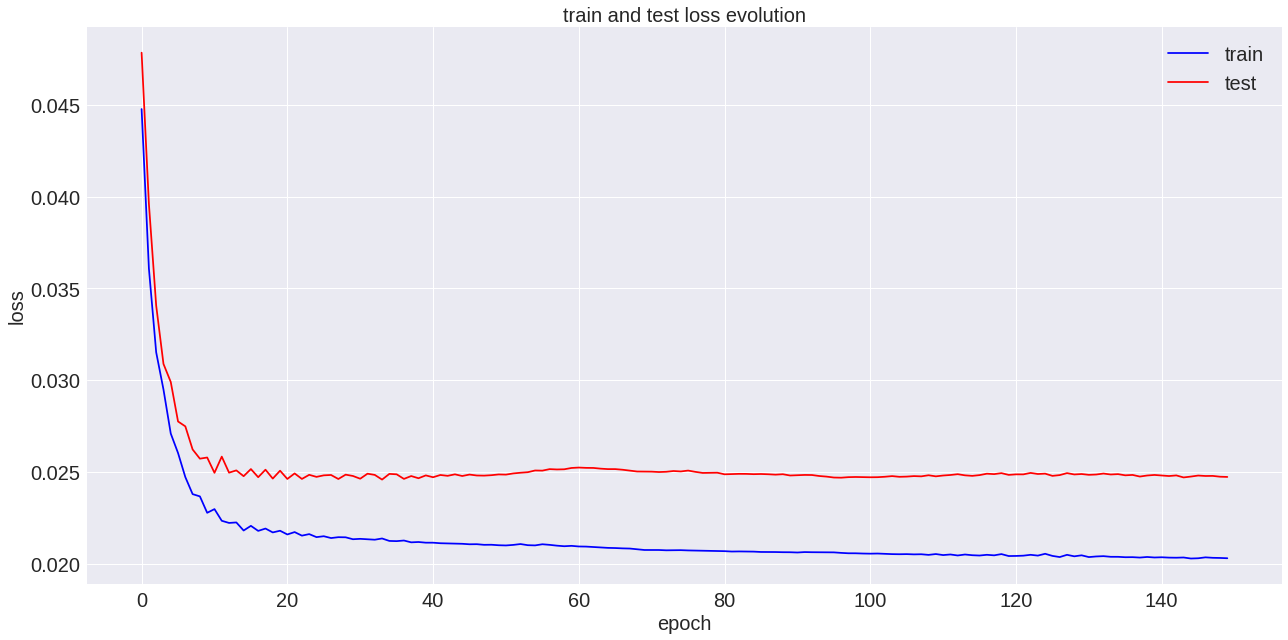

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.996


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 7.033


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.857


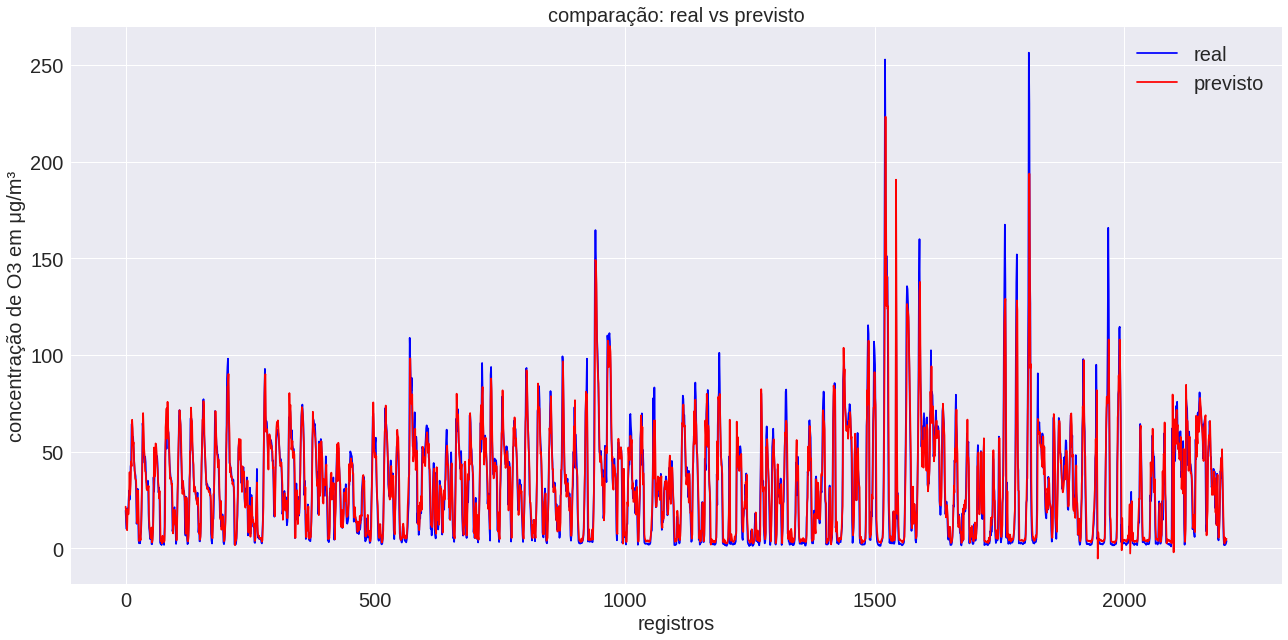

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

#**LAG 4 para teste**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 4
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2007 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
97/97 - 1s - loss: 0.0557 - val_loss: 0.0430
Epoch 2/150
97/97 - 0s - loss: 0.0395 - val_loss: 0.0360
Epoch 3/150
97/97 - 0s - loss: 0.0323 - val_loss: 0.0433
Epoch 4/150
97/97 - 0s - loss: 0.0302 - val_loss: 0.0415
Epoch 5/150
97/97 - 0s - loss: 0.0297 - val_loss: 0.0398
Epoch 6/150
97/97 - 0s - loss: 0.0271 - val_loss: 0.0286
Epoch 7/150
97/97 - 0s - loss: 0.0300 - val_loss: 0.0257
Epoch 8/150
97/97 - 0s - loss: 0.0247 - val_loss: 0.0310
Epoch 9/150
97/97 - 0s - loss: 0.0243 - val_loss: 0.0304
Epoch 10/150
97/97 - 0s - loss: 0.0237 - val_loss: 0.0296
Epoch 11/150
97/97 - 0s - loss: 0.0237 - val_loss: 0.0304
Epoch 12/150
97/97 - 0s - loss: 0.0233 - val_loss: 0.0269
Epoch 13/150
97/97 - 0s - loss: 0.0252 - val_loss: 0.0255
Epoch 14/150
97/97 - 0s - loss: 0.0233 - val_loss: 0.0265
Epoch 15/150
97/97 - 0s - loss: 0.0235 - val_loss: 0.0257
Epoch 16/150
97/97 - 0s - loss: 0.0232 - val_loss: 0.0267
Epoch 17/150
97/97 - 0s - loss: 0.0227 - val_loss: 0.0267
Epoch 18/150
97/97 - 0s

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.964


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.620


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.858


#**LAG 4 sem normalização**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

scaled=values #não normalizado

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 4
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2007 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
97/97 - 1s - loss: 18.6199 - val_loss: 18.2253
Epoch 2/150
97/97 - 0s - loss: 16.4536 - val_loss: 16.3703
Epoch 3/150
97/97 - 0s - loss: 14.9175 - val_loss: 14.9570
Epoch 4/150
97/97 - 0s - loss: 13.7211 - val_loss: 13.7577
Epoch 5/150
97/97 - 0s - loss: 12.6399 - val_loss: 12.6889
Epoch 6/150
97/97 - 0s - loss: 11.6522 - val_loss: 11.7116
Epoch 7/150
97/97 - 0s - loss: 10.8069 - val_loss: 10.9312
Epoch 8/150
97/97 - 0s - loss: 10.1267 - val_loss: 10.2869
Epoch 9/150
97/97 - 0s - loss: 9.5285 - val_loss: 9.7407
Epoch 10/150
97/97 - 0s - loss: 9.0767 - val_loss: 9.2628
Epoch 11/150
97/97 - 0s - loss: 8.6464 - val_loss: 8.8748
Epoch 12/150
97/97 - 0s - loss: 8.3100 - val_loss: 8.4943
Epoch 13/150
97/97 - 0s - loss: 8.0110 - val_loss: 8.2046
Epoch 14/150
97/97 - 0s - loss: 7.7527 - val_loss: 7.9395
Epoch 15/150
97/97 - 0s - loss: 7.5640 - val_loss: 7.7410
Epoch 16/150
97/97 - 0s - loss: 7.3797 - val_loss: 7.5542
Epoch 17/150
97/97 - 0s - loss: 7.2608 - val_loss: 7.4557
Epoch 1

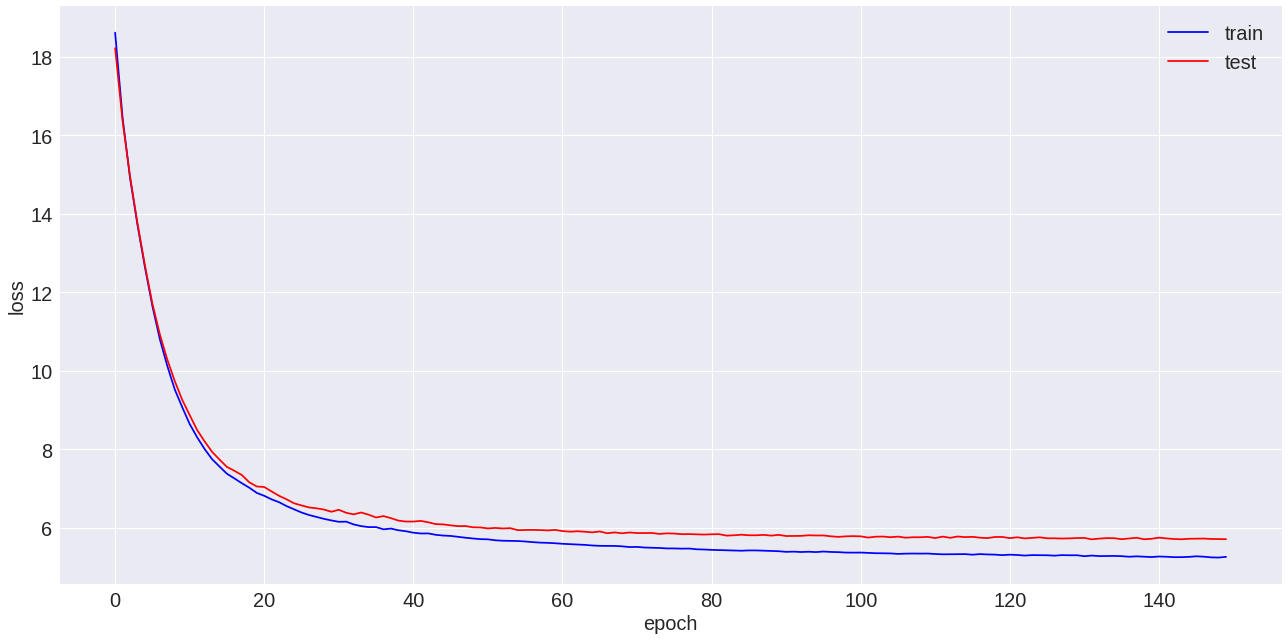

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [ ]:
# invert scaling for forecast (não foi feito)
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = inv_yhat[:,0]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.270


In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 5.713


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.848


#**Modelo VAR**

In [32]:
df_sc_2=df_sc.copy()
df_sc_2.drop(columns=['Hora-minuto', 'Ano', 'Mês', 'Dia', 'Hora'], inplace=True)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_sc_2, variables = df_sc_2.columns)   

,Chuva_x,Pres_x,RS_x,Temp_x,UR_x,Vel_Vento_x,SO2_x,CO_x,O3_x,PM10_x
Chuva_y,1.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0116,0.0,0.0
Pres_y,0.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0
RS_y,0.0000,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0
Temp_y,0.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0
UR_y,0.0000,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,0.0,0.0
Vel_Vento_y,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0000,0.0,0.0
SO2_y,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,0.0000,0.0,0.0
CO_y,0.0755,0.0,0.0,0.0,0.0,0.0,0.0,1.0000,0.0,0.0
O3_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.0,0.0
PM10_y,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,1.0


In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_sc_2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Chuva  ::  43524.12  > 219.4051  =>   True
Pres   ::  32651.6   > 179.5199  =>   True
RS     ::  24455.04  > 143.6691  =>   True
Temp   ::  17705.97  > 111.7797  =>   True
UR     ::  12549.12  > 83.9383   =>   True
Vel_Vento ::  8143.93   > 60.0627   =>   True
SO2    ::  4696.76   > 40.1749   =>   True
CO     ::  1974.96   > 24.2761   =>   True
O3     ::  294.72    > 12.3212   =>   True
PM10   ::  0.0       > 4.1296    =>   False


In [34]:
nobs = 15841
df_train, df_test = df_sc_2[0:-nobs], df_sc_2[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(44520, 10)
(15841, 10)


In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [19]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Chuva" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.9873
 No. Lags Chosen       = 52
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.4063
 No. Lags Chosen       = 56
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [20]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  15.322786429045982
BIC :  15.344291940125867
FPE :  4514416.17742418
HQIC:  15.329559471920694 

Lag Order = 2
AIC :  13.84252034965099
BIC :  13.883577141621824
FPE :  1027377.8631953427
HQIC:  13.855450974883379 

Lag Order = 3
AIC :  13.659665237399828
BIC :  13.720274087714968
FPE :  855691.5399454775
HQIC:  13.67875370277226 

Lag Order = 4
AIC :  13.536419983905624
BIC :  13.616581670067415
FPE :  756471.3873686646
HQIC:  13.561666547217142 

Lag Order = 5
AIC :  13.434851812598192
BIC :  13.53456711215798
FPE :  683411.0738761448
HQIC:  13.466256731664517 

Lag Order = 6
AIC :  13.374586343921878
BIC :  13.493856034480011
FPE :  643441.4795917522
HQIC:  13.412149876575414 

Lag Order = 7
AIC :  13.329073571268394
BIC :  13.467898430474225
FPE :  614813.100098365
HQIC:  13.372795975358228 

Lag Order = 8
AIC :  13.296320181424173
BIC :  13.454700986976063
FPE :  595002.1045599673
HQIC:  13.34620171481607 

Lag Order = 9
AIC :  13.261802479091102
BIC :  13.439

In [21]:
x = model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,33.70,33.70,4.314e+14,33.70
1,15.33,15.35,4.527e+06,15.33
2,13.84,13.89,1.030e+06,13.86
3,13.66,13.72,8.576e+05,13.68
4,13.54,13.62,7.580e+05,13.56
5,13.44,13.54,6.846e+05,13.47
6,13.38,13.50,6.444e+05,13.41
7,13.33,13.47,6.157e+05,13.37
8,13.30,13.46,5.957e+05,13.35
9,13.26,13.44,5.755e+05,13.32


In [35]:
model_fitted = model.fit(4) #aqui vem o LAG
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Nov, 2020
Time:                     10:34:53
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    13.6166
Nobs:                     44516.0    HQIC:                   13.5617
Log likelihood:          -932538.    FPE:                    756471.
AIC:                      13.5364    Det(Omega_mle):         749539.
--------------------------------------------------------------------
Results for equation Chuva
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                6.678751         1.223389            5.459           0.000
L1.Chuva             0.328016         0.004840           67.778           0.000
L1.Pres              0.094412         0.013936            6.775 

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

OBJECTID : 2.0
Data : 2.11
CodNum : 2.03
Estação : 2.02
Chuva : 2.01
Pres : 2.01
RS : 2.0
Temp : 2.01
UR : 2.02
Dir_Vento : 2.01


In [36]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

4


In [37]:
# Input data for forecasting
forecast_input = df_sc_2.values[-lag_order:]
forecast_input

array([[0.00000e+00, 1.00885e+03, 1.00000e+00, 2.82500e+01, 6.87800e+01,
        1.05000e+00, 5.15000e+00, 7.00000e-02, 4.33700e+01, 1.10000e+01],
       [0.00000e+00, 1.00948e+03, 1.00000e+00, 2.81500e+01, 6.73000e+01,
        5.20000e-01, 4.96000e+00, 7.00000e-02, 3.46100e+01, 1.00000e+01],
       [0.00000e+00, 1.00968e+03, 1.00000e+00, 2.82800e+01, 6.45800e+01,
        2.50000e-01, 4.49000e+00, 1.00000e-01, 2.61700e+01, 1.40000e+01],
       [0.00000e+00, 1.00925e+03, 1.00000e+00, 2.78700e+01, 6.84000e+01,
        2.80000e-01, 7.71000e+00, 7.00000e-02, 2.25500e+01, 2.40000e+01]])

In [38]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_sc_2.index[-nobs:], columns=df_sc_2.columns)
df_forecast

,Chuva,Pres,RS,Temp,UR,Vel_Vento,SO2,CO,O3,PM10
Data,,,,,,,,,,
2016-02-23 17:30:00,0.062874,1008.825016,21.549797,27.538590,70.490436,0.378540,7.835496,0.100011,21.336920,24.406337
2016-02-23 18:30:00,0.110574,1008.517626,31.358494,27.291219,71.681886,0.428506,7.364669,0.135764,20.581445,25.388811
2016-02-23 19:30:00,0.096417,1008.440014,34.455214,27.120810,72.512054,0.462223,7.543230,0.184433,18.382892,26.718632
2016-02-23 20:30:00,0.114793,1008.554461,48.648411,27.077552,72.844740,0.515822,8.043935,0.235665,16.627892,28.963396
2016-02-23 21:30:00,0.134022,1008.785995,77.556791,27.205217,72.489879,0.580583,8.758411,0.278107,15.754851,31.376468
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:30:00,0.099584,1014.826326,152.281135,27.538288,74.202670,0.894313,8.369378,0.308734,21.119287,37.624119
2018-01-01 20:30:00,0.099584,1014.826326,152.281135,27.538288,74.202670,0.894313,8.369378,0.308734,21.119287,37.624119
2018-01-01 21:30:00,0.099584,1014.826326,152.281135,27.538288,74.202670,0.894313,8.369378,0.308734,21.119287,37.624119


In [39]:
df_forecast['O3']

Data
2016-02-23 17:30:00    21.336920
2016-02-23 18:30:00    20.581445
2016-02-23 19:30:00    18.382892
2016-02-23 20:30:00    16.627892
2016-02-23 21:30:00    15.754851
                         ...    
2018-01-01 19:30:00    21.119287
2018-01-01 20:30:00    21.119287
2018-01-01 21:30:00    21.119287
2018-01-01 22:30:00    21.119287
2018-01-01 23:30:00    21.119287
Name: O3, Length: 15841, dtype: float64

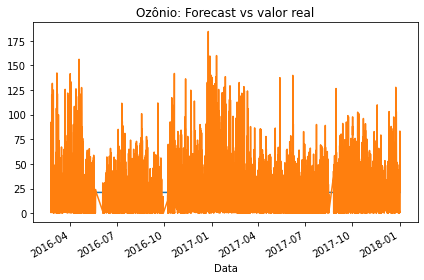

In [40]:
plt.title('Ozônio: Forecast vs valor real')
df_forecast['O3'].plot()
df_test['O3'].plot()
plt.tight_layout();

In [41]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: O3')
accuracy_prod = forecast_accuracy(df_forecast['O3'].values, df_test['O3'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: O3
mape :  inf
me :  -0.7857
mae :  18.565
mpe :  inf
rmse :  23.9239
corr :  0.0133
minmax :  0.5982


In [42]:
from sklearn.metrics import r2_score #colocar citação
# calculate R2
r2=r2_score(df_test['O3'], df_forecast['O3'].values)
print('Test R2: %.3f' % r2)

Test R2: -0.001


#**Best model**

In [ ]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 10
n_features = 10

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 2190 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/150
106/106 - 1s - loss: 0.0600 - val_loss: 0.0357
Epoch 2/150
106/106 - 1s - loss: 0.0397 - val_loss: 0.0301
Epoch 3/150
106/106 - 1s - loss: 0.0344 - val_loss: 0.0281
Epoch 4/150
106/106 - 1s - loss: 0.0312 - val_loss: 0.0261
Epoch 5/150
106/106 - 1s - loss: 0.0298 - val_loss: 0.0249
Epoch 6/150
106/106 - 1s - loss: 0.0281 - val_loss: 0.0241
Epoch 7/150
106/106 - 1s - loss: 0.0269 - val_loss: 0.0234
Epoch 8/150
106/106 - 1s - loss: 0.0261 - val_loss: 0.0229
Epoch 9/150
106/106 - 1s - loss: 0.0254 - val_loss: 0.0225
Epoch 10/150
106/106 - 1s - loss: 0.0250 - val_loss: 0.0223
Epoch 11/150
106/106 - 1s - loss: 0.0246 - val_loss: 0.0220
Epoch 12/150
106/106 - 1s - loss: 0.0243 - val_loss: 0.0218
Epoch 13/150
106/106 - 1s - loss: 0.0242 - val_loss: 0.0218
Epoch 14/150
106/106 - 1s - loss: 0.0240 - val_loss: 0.0216
Epoch 15/150
106/106 - 1s - loss: 0.0239 - val_loss: 0.0217
Epoch 16/150
106/106 - 1s - loss: 0.0237 - val_loss: 0.0215
Epoch 17/150
106/106 - 1s - loss: 0.0238 - val_lo

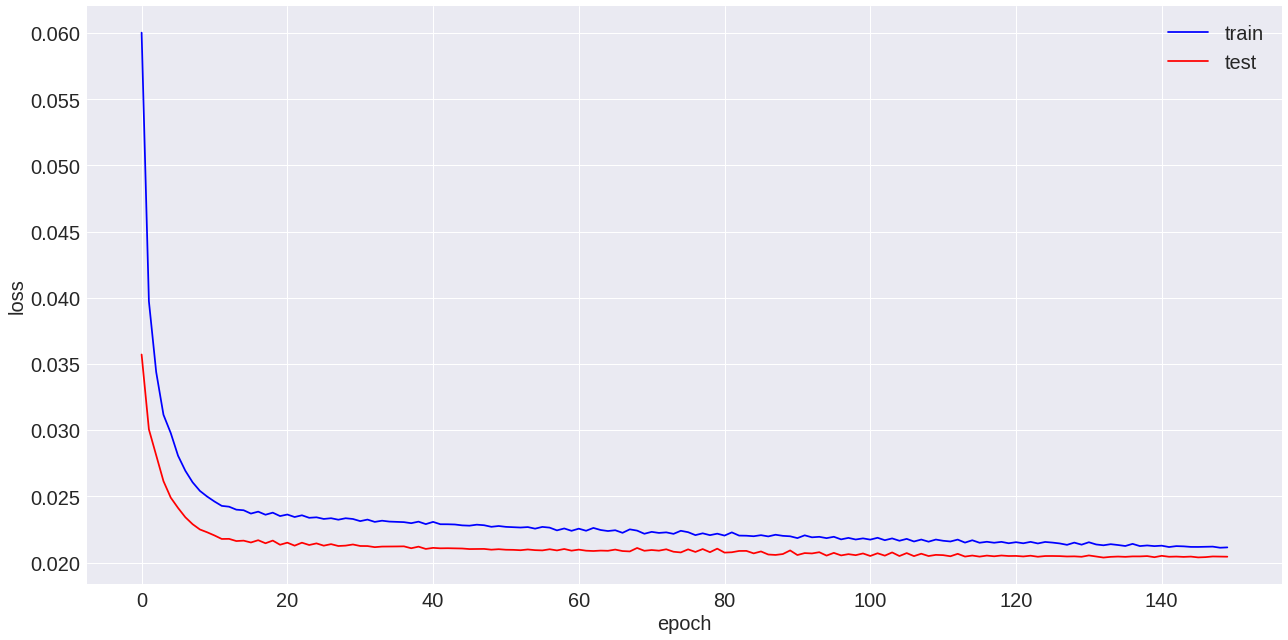

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.005


In [ ]:
#rodar de novo os lag=2,4,6,8,10,12

In [ ]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 4.997


In [ ]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.859


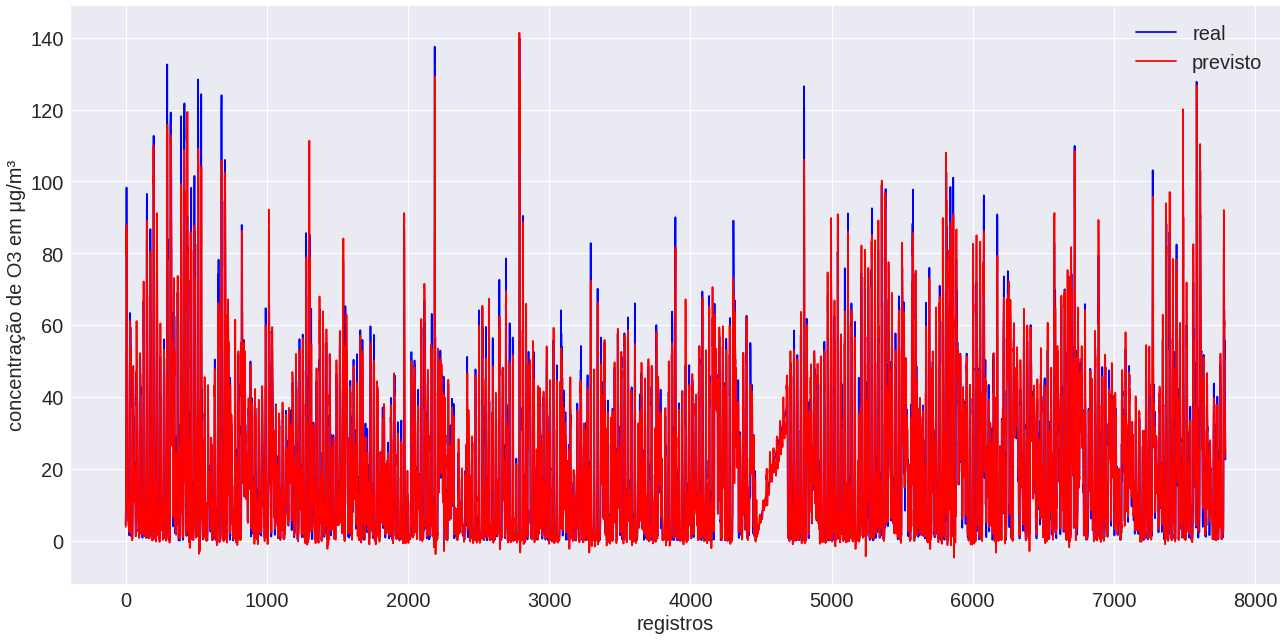

In [ ]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
# plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()